In [1]:
import yfinance as yf
import gurobipy as gp
from gurobipy import GRB
from math import sqrt
import pandas as pd
"""## Collecting Data"""
stocks = ['TATAMOTORS.NS', 'TATAPOWER.NS', 'RELIANCE.NS',
'SUZLON.NS','MMTC.NS', 'ADANIPOWER.NS', 'ADANIPORTS.NS', 'IOC.NS',
'YESBANK.NS', 'ZOMATO.NS', 'AWL.NS', 'TITAN.NS', 'ASIANPAINT.NS',
'BANDHANBNK.NS', 'IDBI.NS', 'JWL.NS', 'NHPC.NS', 'VEDL.NS', 'WIPRO.NS',
'TECHM.NS', 'MCX.NS', 'PNB.NS', 'JIOFIN.NS', 'GSPL.NS', 'AXISBANK.NS',
'IRFC.NS', 'RVNL.NS', 'BHEL.NS', 'IREDA.NS', 'GLAXO.NS']
data = yf.download(stocks, period='1y') # period= '2y', '5y'
data=data.dropna()
print(data)
"""## Compute Mean and Variance matrix"""

[*********************100%%**********************]  30 of 30 completed


Price          Adj Close                                                       \
Ticker     ADANIPORTS.NS ADANIPOWER.NS ASIANPAINT.NS      AWL.NS  AXISBANK.NS   
Date                                                                            
2023-11-29    831.980408    433.100006   3118.179932  347.299988  1059.332520   
2023-11-30    821.973328    431.500000   3090.002441  340.649994  1073.421631   
2023-12-01    824.263489    440.399994   3142.989746  340.250000  1103.798218   
2023-12-04    874.896301    464.700012   3163.937256  346.250000  1124.731934   
2023-12-05   1008.771851    538.150024   3195.333496  380.649994  1131.576660   
...                  ...           ...           ...         ...          ...   
2024-07-08   1475.300049    698.049988   2898.149902  339.299988  1286.856812   
2024-07-09   1478.000000    724.950012   2905.000000  338.299988  1288.405640   
2024-07-10   1487.800049    727.549988   2996.449951  335.000000  1290.653931   
2024-07-11   1483.849976    

'## Compute Mean and Variance matrix'

In [2]:
import numpy as np
closes = np.transpose(np.array(data.Close)) # matrix of daily closing prices
absdiff = np.diff(closes) # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price
delta = np.mean(reldiff, axis=1) # mean price change
sigma = np.cov(reldiff) # covariance
std = np.std(reldiff, axis=1) # standard deviation

In [3]:
"""## Minimize risk by solving QP model"""
# Create an empty model
m = gp.Model('portfolio')
# Add matrix variable for the stocks
x = m.addMVar(len(stocks))
# Objective is to minimize risk (squared). This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)
# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')
# Verify model formulation
m.write('portfolio_selection_optimization.lp')
# Optimize model to find the minimum risk portfolio
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-16
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 30 columns and 30 nonzeros
Model fingerprint: 0x6fab87ea
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-05, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 30 columns, 30 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Resi

In [4]:
"""## Display minimum risk portfolio using Pandas"""
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])


,Minimum Risk Portfolio
TATAMOTORS.NS,6.577199e-09
TATAPOWER.NS,1.386446e-08
RELIANCE.NS,3.251537e-01
SUZLON.NS,2.032596e-02
MMTC.NS,1.410492e-01
ADANIPOWER.NS,2.383297e-08
ADANIPORTS.NS,6.724448e-09
IOC.NS,2.425369e-02
YESBANK.NS,1.082646e-01
ZOMATO.NS,1.024708e-08


In [5]:
"""## Compute the efficient frontier"""
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')
# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2 rows, 30 columns and 60 nonzeros
Model fingerprint: 0x9b59308b
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-05, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 1e+00]
Presolve time: 0.02s
Presolved: 2 rows, 30 columns, 60 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.650e+02
 Factor NZ  : 4.960e+02
 Factor Ops : 1.042e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.558

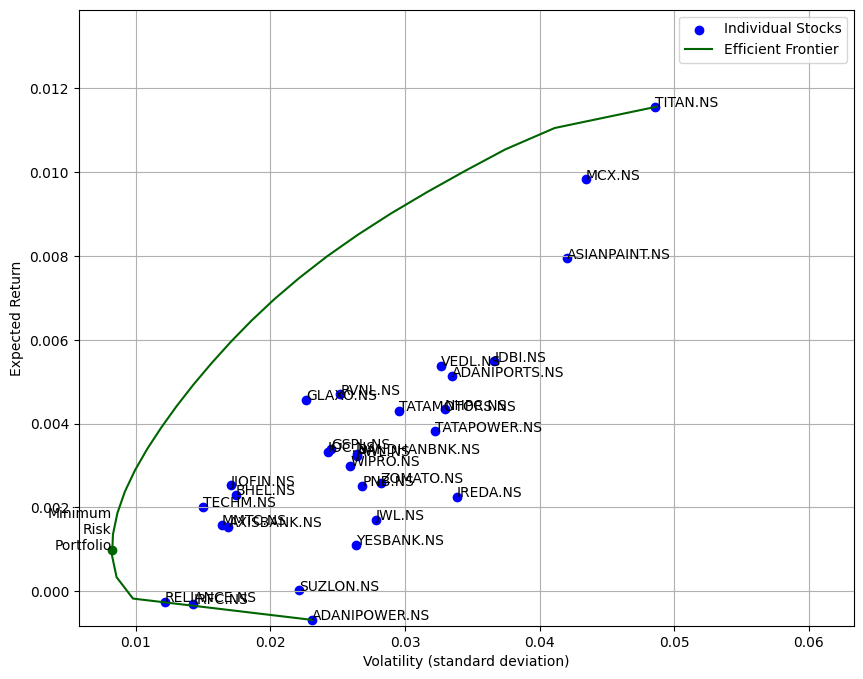

In [6]:
"""## Plot results"""
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,8))
# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))
# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility,
minrisk_return),
horizontalalignment='right')
# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier',
color='DarkGreen')
# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2,
delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()


In [7]:
"""Sharpe Ratio Optimization"""
# Create an empty model
m = gp.Model('sharp_ratio_portfolio')
# Add matrix variable for the stocks
x = m.addMVar(len(stocks))
# Objective is to minimize risk (squared). This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ (sigma- (1.02**(1/252)-1)/100)/std @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)
# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')
# Verify model formulation
m.write('portfolio_selection_optimization_sharpe.lp')
# Optimize model to find the minimum risk portfolio
m.optimize()
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 30 columns and 30 nonzeros
Model fingerprint: 0x61a8333b
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-04, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 30 columns, 30 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.297

,Minimum Risk Portfolio
TATAMOTORS.NS,2.712434e-11
TATAPOWER.NS,8.655890e-10
RELIANCE.NS,2.150441e-01
SUZLON.NS,3.959229e-02
MMTC.NS,1.483476e-01
ADANIPOWER.NS,1.292510e-10
ADANIPORTS.NS,2.869342e-11
IOC.NS,5.403294e-02
YESBANK.NS,1.613470e-01
ZOMATO.NS,3.308822e-11


In [8]:
"""Sharpe Ratio with Constraint on min and max limit of investment
"""
# Create an empty model
m = gp.Model('sharp_ratio_portfolio')
# Add matrix variable for the stocks
x = m.addMVar(len(stocks))
# Objective is to minimize risk (squared). This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ (sigma- (1.02**(1/252)-1)/100)/std @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)
# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')
for i in range(len(stocks)):
    m.addConstr(x[i] <= 0.3)
# Verify model formulation
m.write('portfolio_selection_optimization_sharpe.lp')
# Optimize model to find the minimum risk portfolio
m.optimize()
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 31 rows, 30 columns and 60 nonzeros
Model fingerprint: 0x1ac28482
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-04, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve removed 30 rows and 0 columns
Presolve time: 0.01s
Presolved: 1 rows, 30 columns, 30 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal

,Minimum Risk Portfolio
TATAMOTORS.NS,1.308998e-10
TATAPOWER.NS,1.638274e-09
RELIANCE.NS,2.150441e-01
SUZLON.NS,3.959223e-02
MMTC.NS,1.483476e-01
ADANIPOWER.NS,6.037582e-10
ADANIPORTS.NS,1.413421e-10
IOC.NS,5.403294e-02
YESBANK.NS,1.613470e-01
ZOMATO.NS,1.587562e-10


In [9]:
"""## Sharpe Ratio with constratint on both max investment and number of
stocks held"""
# Create an empty model
m = gp.Model('sharp_ratio_portfolio')
# Add matrix variable for the stocks
x = m.addMVar(len(stocks))
y = m.addMVar(len(stocks), vtype=GRB.BINARY) # Binary decision variables
# Objective is to minimize risk (squared). This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ (sigma- (1.02**(1/252)-1)/100)/std @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)
# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')
for i in range(len(stocks)):
    m.addConstr(x[i] <= 0.3)
# Limit on number of stocks to invest in
max_stocks_to_invest = 20 # Define your maximum number of stocks to invest in
m.addConstr(y.sum() == max_stocks_to_invest, 'max_stocks')
# # Linearization constraint: Ensure x_i is zero if y_i is zero
for i in range(len(stocks)):
    m.addConstr(y[i] >= x[i]) # Ensure y[i] = 1 if x[i] > 0
    m.addConstr(x[i] <= y[i] * 0.1) # Ensure y[i] = 0 if x[i] = 0
# Verify model formulation
m.write('portfolio_selection_optimization_sharpe.lp')
# Optimize model to find the minimum risk portfolio
m.optimize()
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 92 rows, 60 columns and 210 nonzeros
Model fingerprint: 0x7d2c5522
Model has 465 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-04, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+01]
Found heuristic solution: objective 0.0095669
Presolve removed 60 rows and 0 columns
Presolve time: 0.00s
Presolved: 46 rows, 67 columns, 148 nonzeros
Presolved model has 472 quadratic objective terms
Variable types: 37 continuous, 30 integer (30 binary)

Root relaxation: objective 4.328759e-03, 95 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |

,Minimum Risk Portfolio
TATAMOTORS.NS,0.000000
TATAPOWER.NS,0.000000
RELIANCE.NS,0.100000
SUZLON.NS,0.058521
MMTC.NS,0.100000
ADANIPOWER.NS,0.000000
ADANIPORTS.NS,0.000000
IOC.NS,0.085707
YESBANK.NS,0.100000
ZOMATO.NS,0.000000
